# DQN for Atari Pong (Assignment 3)

This notebook implements a modular Deep Q-Network (DQN) for **Pong** using Gymnasium Atari environment. It includes preprocessing (frame crop/downsample/grayscale/normalize), 4-frame stacking as input to a CNN, a replay buffer, target network updates, and facilities to run the required experiments (batch size and target-update frequency).

**How to use**: install dependencies, run the training cells (training can take a long time — the notebook provides hooks to run shorter tests), and run the experiment cells to produce the plots required for the assignment.

---

**Files used**:
- `assignment3_utils.py` (should be in the same directory)



In [1]:
import os, random, math, time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim

# Gymnasium import for Atari
import gymnasium as gym
import ale_py

# Import preprocessing utilities (assignment3_utils.py must be present)
from assignment3_utils import process_frame, transform_reward

## Environment helper
We create the Atari Pong environment using Gymnasium. The notebook uses `ALE/PongNoFrameskip-v5` which gives access to raw frames (no frameskip wrapper applied). We will handle frame stacking and preprocessing manually.

In [2]:
def make_env(env_id='ALE/Pong-v5'):
    # Create environment. Do not render here.
    env = gym.make(env_id, frameskip=1, repeat_action_probability=0, full_action_space=False)
    return env

# quick sanity check (will not run the full env loop)
env = make_env()
obs, info = env.reset(seed=42)
print('Reset obs shape:', obs.shape)
env.close()

Reset obs shape: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


## Preprocessing and frame stacking
We rely on `assignment3_utils.process_frame` which returns a processed single frame with shape `(1, H, W, 1)` (batch-like dim, height, width, channel=1). We'll maintain a deque of the last 4 processed frames and concatenate along the channel axis to produce a state of shape `(1, H, W, 4)` which we then transpose to `(1, 4, H, W)` for PyTorch.

In [3]:
IMAGE_SHAPE = (84, 80)  # (height, width) after crop+downsample

def init_frame_stack():
    return deque(maxlen=4)

def stack_initial_frames(frame_stack, processed_frame):
    # processed_frame is expected to be shape (1, H, W, 1)
    frame_stack.append(processed_frame)
    # pad with the first frame if needed
    while len(frame_stack) < 4:
        frame_stack.append(processed_frame)
    state = np.concatenate(list(frame_stack), axis=3)  # shape (1, H, W, 4)
    return state, frame_stack

def append_frame(frame_stack, processed_frame):
    frame_stack.append(processed_frame)
    state = np.concatenate(list(frame_stack), axis=3)
    return state, frame_stack

# quick test using the env
env = make_env()
obs, info = env.reset(seed=0)
proc = process_frame(obs, IMAGE_SHAPE)  # shape (1,H,W,1)
fs = init_frame_stack()
state, fs = stack_initial_frames(fs, proc)
print('processed_frame shape:', proc.shape, 'state shape (NHWC):', state.shape)
env.close()

processed_frame shape: (1, 84, 80, 1) state shape (NHWC): (1, 84, 80, 4)


## Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # states expected as numpy arrays with shapes like (1,H,W,4)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # concatenate along batch dim
        states = np.concatenate(states, axis=0)          # (B, H, W, C)
        next_states = np.concatenate(next_states, axis=0)
        return states, np.array(actions), np.array(rewards), next_states, np.array(dones)
    
    def __len__(self):
        return len(self.buffer)

## DQN network (PyTorch)
The CNN follows the common Atari DQN design but adjusted for input shape (4 stacked grayscale frames). Final layer outputs Q-values for the action space (6 actions in Pong).

In [5]:
class DQN(nn.Module):
    def __init__(self, input_channels=4, num_actions=6):
        super().__init__()
        # Input: (batch, 4, 84, 80)
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # -> approx (32, 20, 19)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),             # -> approx (64, 9, 8)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),             # -> approx (64, 7, 6)
            nn.ReLU(),
            nn.Flatten()
        )
        # compute flattened size by running a dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, IMAGE_SHAPE[0], IMAGE_SHAPE[1])
            n_flatten = self.features(dummy).shape[1]
        
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
    
    def forward(self, x):
        # Expect x in float32 and in range approx [-1,1] (assignment util normalizes)
        return self.fc(self.features(x))

## Training function (modular)
`train_dqn` trains one run with specified hyperparameters and returns recorded metrics and the trained policy network. It does **not** render. It saves optional plots to disk.

In [6]:
def train_dqn(num_episodes=200,
              batch_size=8,
              gamma=0.95,
              lr=1e-4,
              replay_capacity=50000,
              target_update_episodes=10,
              eps_start=1.0,
              eps_decay=0.995,
              eps_min=0.05,
              device=None,
              env_id='ALE/Pong-v5',
              save_plots_prefix="Plots",
              verbose=True):
    
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    env = gym.make(env_id, frameskip=1, repeat_action_probability=0, full_action_space=False)
    num_actions = env.action_space.n
    
    policy_net = DQN(input_channels=4, num_actions=num_actions).to(device)
    target_net = DQN(input_channels=4, num_actions=num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer(capacity=replay_capacity)
    
    scores = []
    avg5 = []
    epsilon = eps_start
    total_steps = 0  # cumulative steps across all episodes

    for ep in range(1, num_episodes+1):
        obs, info = env.reset()
        proc = process_frame(obs, IMAGE_SHAPE)  # shape (1,H,W,1)
        frame_stack = init_frame_stack()
        state, frame_stack = stack_initial_frames(frame_stack, proc)  # state: (1,H,W,4)

        done = False
        ep_reward = 0
        steps = 0  # steps in current episode

        while not done:
            steps += 1
            # ε-greedy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                s = torch.tensor(np.transpose(state, (0,3,1,2)), dtype=torch.float32).to(device)  # (1,4,H,W)
                with torch.no_grad():
                    q = policy_net(s)
                action = int(torch.argmax(q, dim=1).item())

            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            reward_clipped = transform_reward(reward)
            proc_next = process_frame(next_obs, IMAGE_SHAPE)
            next_state, frame_stack = append_frame(frame_stack, proc_next)

            memory.push(state, action, reward_clipped, next_state, done)
            state = next_state
            ep_reward += reward_clipped

            # learning step
            if len(memory) >= batch_size:
                states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)
                states_t = torch.tensor(np.transpose(states_b, (0,3,1,2)), dtype=torch.float32).to(device)
                next_states_t = torch.tensor(np.transpose(next_states_b, (0,3,1,2)), dtype=torch.float32).to(device)
                actions_t = torch.tensor(actions_b, dtype=torch.long).to(device)
                rewards_t = torch.tensor(rewards_b, dtype=torch.float32).to(device)
                dones_t = torch.tensor(dones_b, dtype=torch.float32).to(device)

                q_values = policy_net(states_t).gather(1, actions_t.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q_values = target_net(next_states_t).max(1)[0]
                expected = rewards_t + gamma * next_q_values * (1 - dones_t)

                loss = nn.MSELoss()(q_values, expected)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # update cumulative steps
        total_steps += steps

        # end episode metrics
        scores.append(ep_reward)
        avg = np.mean(scores[-5:]) if len(scores) >= 5 else np.mean(scores)
        avg5.append(avg)

        # decay epsilon
        if epsilon > eps_min:
            epsilon = max(epsilon * eps_decay, eps_min)

        # update target network every N episodes
        if ep % target_update_episodes == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if verbose:
            print(f"Ep {ep}/{num_episodes} | Total Steps: {total_steps} | Reward: {ep_reward:.2f} | Avg5: {avg:.2f} | Eps: {epsilon:.3f}")

    env.close()

    # optional saving plots
    if save_plots_prefix:
        plt.figure(figsize=(10,5))
        plt.plot(scores, label='Score per episode')
        plt.plot(avg5, label='Avg last 5')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.title(f'DQN training ({save_plots_prefix})')
        plt.savefig(f'{save_plots_prefix}_training.png', bbox_inches='tight')
        plt.close()

    return policy_net, scores, avg5


## Utility: run experiments for the assignment
This cell runs (but commented out by default) three experiments you need for the report:

1. Default: batch_size=8, target_update=10
2. Batch experiment: batch_size=16, target_update=10
3. Target update experiment: batch_size=8, target_update=3

**Note**: training for many episodes can take hours on CPU. For development you can set `num_episodes=20` or similar. Uncomment and modify before running.

Ep 1/10 | Total Steps: 3280 | Reward: -21.00 | Avg5: -21.00 | Eps: 0.995
Ep 2/10 | Total Steps: 6336 | Reward: -21.00 | Avg5: -21.00 | Eps: 0.990
Ep 3/10 | Total Steps: 9747 | Reward: -21.00 | Avg5: -21.00 | Eps: 0.985
Ep 4/10 | Total Steps: 13805 | Reward: -19.00 | Avg5: -20.50 | Eps: 0.980
Ep 5/10 | Total Steps: 17710 | Reward: -19.00 | Avg5: -20.20 | Eps: 0.975
Ep 6/10 | Total Steps: 20766 | Reward: -21.00 | Avg5: -20.20 | Eps: 0.970
Ep 7/10 | Total Steps: 24174 | Reward: -21.00 | Avg5: -20.20 | Eps: 0.966
Ep 8/10 | Total Steps: 27230 | Reward: -21.00 | Avg5: -20.20 | Eps: 0.961
Ep 9/10 | Total Steps: 30638 | Reward: -21.00 | Avg5: -20.60 | Eps: 0.956
Ep 10/10 | Total Steps: 34012 | Reward: -20.00 | Avg5: -20.80 | Eps: 0.951
Ep 1/10 | Total Steps: 3373 | Reward: -20.00 | Avg5: -20.00 | Eps: 0.995
Ep 2/10 | Total Steps: 6724 | Reward: -20.00 | Avg5: -20.00 | Eps: 0.990
Ep 3/10 | Total Steps: 10443 | Reward: -20.00 | Avg5: -20.00 | Eps: 0.985
Ep 4/10 | Total Steps: 14048 | Reward: -20

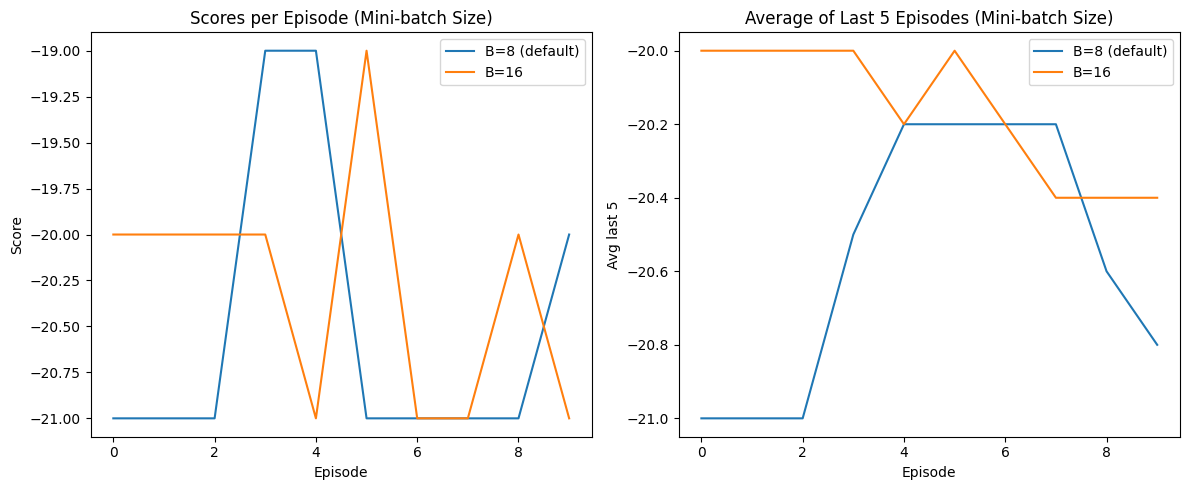

Ep 1/10 | Total Steps: 3371 | Reward: -21.00 | Avg5: -21.00 | Eps: 0.995
Ep 2/10 | Total Steps: 7785 | Reward: -17.00 | Avg5: -19.00 | Eps: 0.990
Ep 3/10 | Total Steps: 11193 | Reward: -21.00 | Avg5: -19.67 | Eps: 0.985
Ep 4/10 | Total Steps: 14489 | Reward: -21.00 | Avg5: -20.00 | Eps: 0.980
Ep 5/10 | Total Steps: 18310 | Reward: -19.00 | Avg5: -19.80 | Eps: 0.975
Ep 6/10 | Total Steps: 21801 | Reward: -20.00 | Avg5: -19.60 | Eps: 0.970
Ep 7/10 | Total Steps: 25449 | Reward: -21.00 | Avg5: -20.40 | Eps: 0.966
Ep 8/10 | Total Steps: 29097 | Reward: -21.00 | Avg5: -20.40 | Eps: 0.961
Ep 9/10 | Total Steps: 33020 | Reward: -19.00 | Avg5: -20.00 | Eps: 0.956
Ep 10/10 | Total Steps: 36387 | Reward: -20.00 | Avg5: -20.20 | Eps: 0.951
Ep 1/10 | Total Steps: 4641 | Reward: -20.00 | Avg5: -20.00 | Eps: 0.995
Ep 2/10 | Total Steps: 7697 | Reward: -21.00 | Avg5: -20.50 | Eps: 0.990
Ep 3/10 | Total Steps: 10869 | Reward: -21.00 | Avg5: -20.67 | Eps: 0.985
Ep 4/10 | Total Steps: 14476 | Reward: -2

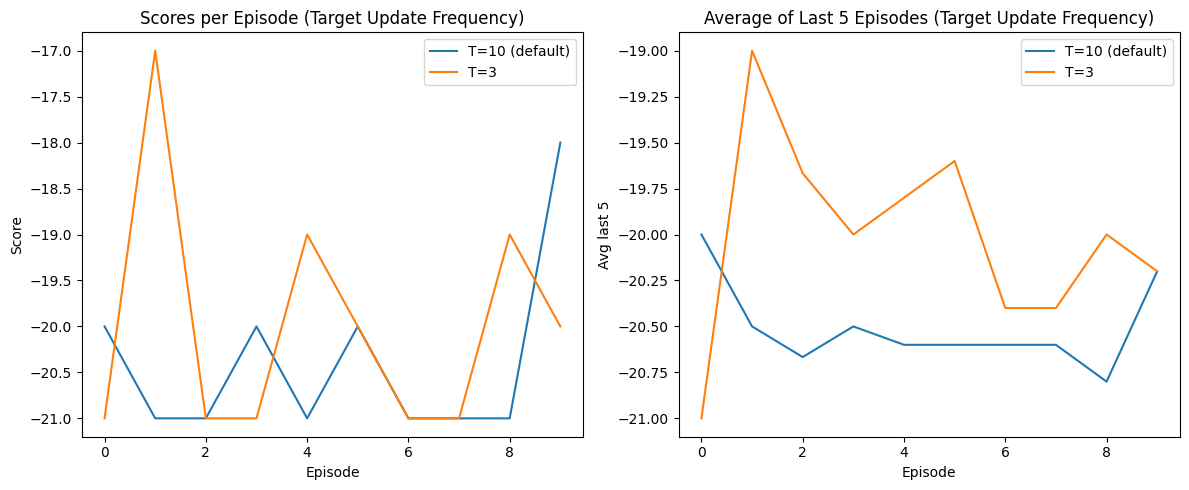

In [7]:
if __name__ == '__main__':
    # -------------------------------
    # 1️⃣ Mini-batch size experiment
    # -------------------------------
    policy_default, scores_default, avg_default = train_dqn(
        num_episodes=10, batch_size=8, target_update_episodes=10,
        save_plots_prefix='default_run', verbose=True
    )
    policy_batch16, scores_b16, avg_b16 = train_dqn(
        num_episodes=10, batch_size=16, target_update_episodes=10,
        save_plots_prefix='batch16_run', verbose=True
    )

    # Plot metrics for mini-batch size experiment
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(scores_default, label='B=8 (default)')
    plt.plot(scores_b16, label='B=16')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Scores per Episode (Mini-batch Size)')

    plt.subplot(1,2,2)
    plt.plot(avg_default, label='B=8 (default)')
    plt.plot(avg_b16, label='B=16')
    plt.xlabel('Episode')
    plt.ylabel('Avg last 5')
    plt.legend()
    plt.title('Average of Last 5 Episodes (Mini-batch Size)')

    plt.tight_layout()
    plt.show()

    # ------------------------------------------
    # 2️⃣ Target network update frequency experiment
    # ------------------------------------------
    policy_target3, scores_t3, avg_t3 = train_dqn(
        num_episodes=10, batch_size=8, target_update_episodes=3,
        save_plots_prefix='target3_run', verbose=True
    )
    policy_target10, scores_t10, avg_t10 = train_dqn(
        num_episodes=10, batch_size=8, target_update_episodes=10,
        save_plots_prefix='target10_run', verbose=True
    )

    # Plot metrics for target update frequency experiment
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(scores_t10, label='T=10 (default)')
    plt.plot(scores_t3, label='T=3')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Scores per Episode (Target Update Frequency)')

    plt.subplot(1,2,2)
    plt.plot(avg_t10, label='T=10 (default)')
    plt.plot(avg_t3, label='T=3')
    plt.xlabel('Episode')
    plt.ylabel('Avg last 5')
    plt.legend()
    plt.title('Average of Last 5 Episodes (Target Update Frequency)')

    plt.tight_layout()
    plt.show()


## Notes and next steps
- For the full assignment runs, set `num_episodes` to a larger number (e.g. 300-1000) depending on available compute and time.
- Save produced PNG plots and include them in the report PDF.
- You may want to add model saving (`torch.save`) at checkpoints.
- If you need a training resume mechanism, we can add it.

---

If you want, I can now:
- Run a short debug training here (low episodes) to ensure everything executes in this environment,
- Or increase the notebook to include model saving, evaluation (playback), and automatic PDF report skeleton.

Which would you like next?